# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lakemodel_function import lake_problem as lake_model

from scipy.integrate import odeint
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

model = Model('LAKEMODEL', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('q', 2, 4.5),
                       RealParameter("stdev", 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

model.levers = [RealParameter(f'l{i}', 0,0.1) for i in range(100)]


model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [55]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
experiments, outcomes = results

In [9]:
# Remove the policy lever columns
experiments.drop(labels = [f'l{i}' for i in range(100)], axis = 1, inplace = True)

In [22]:
experiments.head(5)

,b,delta,mean,q,stdev,policy,model
0,0.299278,0.944508,0.033129,3.304307,0.004074,0,LAKEMODEL
1,0.275528,0.937176,0.013855,4.001683,0.002481,0,LAKEMODEL
2,0.206847,0.981209,0.027550,3.135819,0.003473,0,LAKEMODEL
3,0.390046,0.969121,0.010995,2.868321,0.004117,0,LAKEMODEL
4,0.326713,0.966718,0.018255,4.220606,0.001723,0,LAKEMODEL


In [11]:
#Find the threshold for the 10% worst reliability 
np.sort(outcomes['reliability'])[999] # Since there are 10000 outcomes, then the 1000th outcome should be the threshold. 

0.050700000000000044

In [17]:
from ema_workbench.analysis import prim

x = experiments.iloc[:,0:4]
y = outcomes['reliability'] < 0.05
prim_alg = prim.Prim(x, y, threshold = 0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 715 cases of interest
[MainProcess/INFO] mean: 0.8627450980392157, mass: 0.051, coverage: 0.6153846153846154, density: 0.8627450980392157 restricted_dimensions: 3


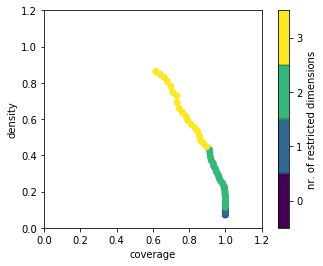

In [18]:
box1.show_tradeoff()
plt.show()

In [19]:
box1.inspect_tradeoff()

alt.VConcatChart(...)

coverage    0.812587
density     0.569608
id                43
mass           0.102
mean        0.569608
res_dim            3
Name: 43, dtype: object

        box 43                                          
           min       max                       qp values
q     2.001082  2.642242  [-1.0, 2.695326678695101e-171]
b     0.100119  0.241710  [-1.0, 2.303580575342981e-106]
mean  0.012088  0.049990     [0.08350639404896738, -1.0]



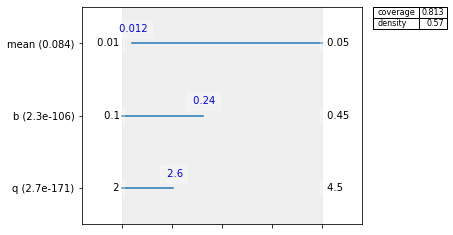

In [20]:
box1.inspect(43)
box1.inspect(43, style='graph')
plt.show()

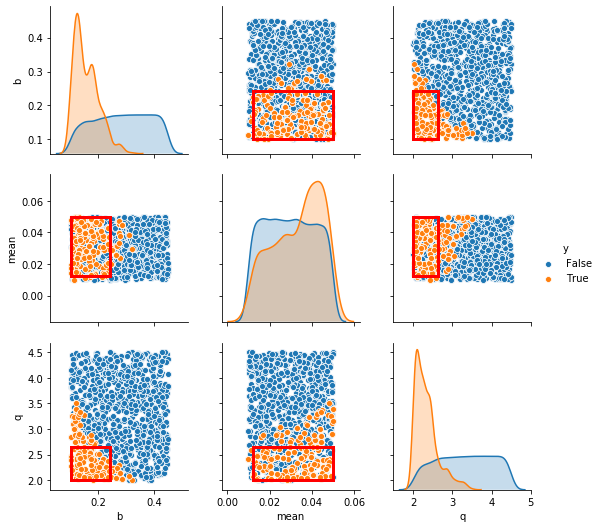

In [21]:
box1.show_pairs_scatter(43)
plt.show()

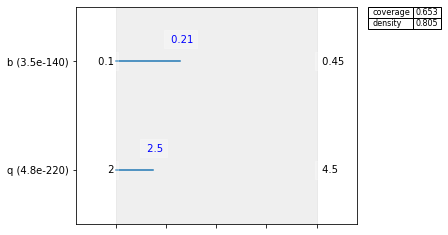

In [29]:
box1.drop_restriction('mean')
box1.inspect(style='graph')
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


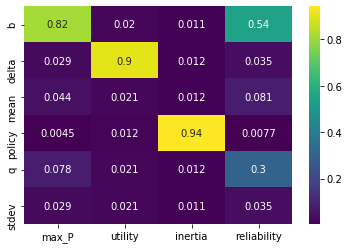

In [33]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns


fs = feature_scoring.get_feature_scores_all(experiments, outcomes)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

From the feature scoring map, we can see that reliability is mainly influenced by b & p

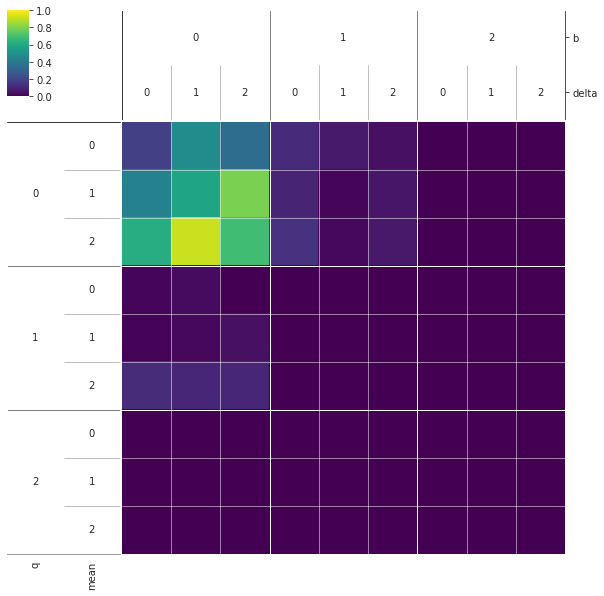

In [24]:
from ema_workbench.analysis import dimensional_stacking
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()

We can see from this visual that if b is low,  while q is low, we have a high concentration of cases where reliability has bad performance. It comforms with the results in scenario discovery